<a href="https://colab.research.google.com/github/plaban1981/Advanced_Nlp_Pinecone/blob/main/Cohere_AI's_LLM_for_Semantic_Search_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

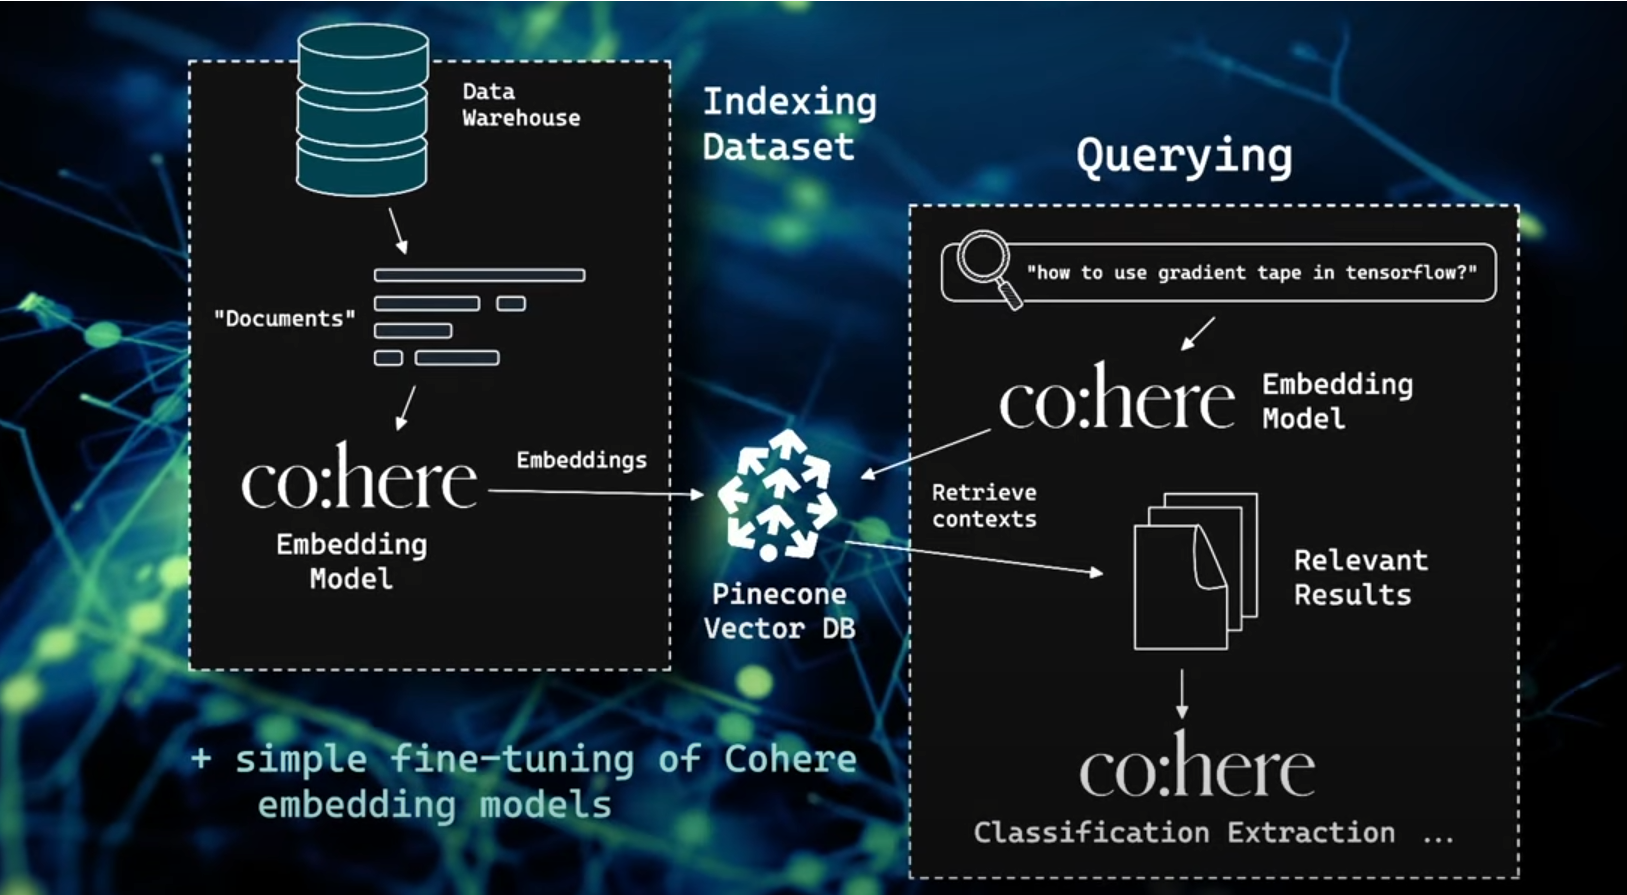

In [3]:
!pip install cohere pinecone-client datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.2 MB/s eta 0:00:00
  Created wheel for cohere: filename=cohere-3.1.3-cp38-cp38-linux_x86_64.whl size=10202 sha256=59b1ba4358cd093c778ee6daa5084f0b8985682959612484c72b2e20236f4431
  Stored in directory: /root/.cache/pip/wheels/5e/f9/3d/e35b35a022b389131dc16cd3ec55c4834c9f97b87f5aff4657
Successfully built cohere
 

* https://dashboard.cohere.ai/
* https://app.pinecone.io/

In [1]:
PINECONE_KEY = 'd7f7ba67-9483-4026-a189-b0547e9ca5ff'
COHERE_KEY = 'nHgu9HiTRoiJnlEIpUJQxJwcv5zoZMdTq7yymzpw' #trail api

import cohere
from cohere.classify import Example

co = cohere.Client('nHgu9HiTRoiJnlEIpUJQxJwcv5zoZMdTq7yymzpw') #This is your trial API key
response = co.classify(
  model='finance-sentiment',
  inputs=["<YOUR_INPUTS>"])

print('The confidence levels of the labels are: {}'.format(response.classifications))

## Create Embeddings

In [12]:
import cohere
co = cohere.Client('jdSQVbSluL5fOumC8V8qBd6krQwhcPhtCun4AZW1')

## Load Dataset

In [4]:
from datasets import load_dataset
#load first 100k records from TREC dataset
trec = load_dataset('trec',split='train[:2000]')
trec

Generating train split:   0%|          | 0/5452 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset trec downloaded and prepared to /root/.cache/huggingface/datasets/trec/default/2.0.0/f2469cab1b5fceec7249fda55360dfdbd92a7a5b545e91ea0f78ad108ffac1c2. Subsequent calls will reuse this data.


Dataset({
    features: ['text', 'coarse_label', 'fine_label'],
    num_rows: 2000
})

## Display first row

In [5]:
trec[0]

{'text': 'How did serfdom develop in and then leave Russia ?',
 'coarse_label': 2,
 'fine_label': 26}

In [6]:
trec['text'][:5]

['How did serfdom develop in and then leave Russia ?',
 'What films featured the character Popeye Doyle ?',
 "How can I find a list of celebrities ' real names ?",
 'What fowl grabs the spotlight after the Chinese Year of the Monkey ?',
 'What is the full form of .com ?']

## Pass the questions to Cohere to create Embeddings

In [7]:
type(trec['text'])

list

In [8]:
import cohere
co = cohere.Client('nHgu9HiTRoiJnlEIpUJQxJwcv5zoZMdTq7yymzpw')
response = co.embed(
  model='small',
  texts=trec['text'][:1000])
print('Embeddings: {}'.format(response.embeddings))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
embed = response.embeddings

In [10]:
len(embed)

1000

In [11]:
import numpy as np
shape = np.array(embed).shape

In [12]:
shape

(1000, 1024)

* 1024 embedding dimensionality produced by cohere'ssmall modeland 1000 samples we built embeddings for.

## Storing the embeddings

* Move on to indexing them in Pinecone vector database.
* Create a new index for storing the embeddings making sure to specify that we would like to use the cosine similarity metric to align with Cohere's embeddings.

In [13]:
import pinecone
pinecone.init(PINECONE_KEY,environment='us-west1-gcp')
index_name = 'cohere-pinecone-trec'

In [14]:
#if index does not exist create it
if index_name not in pinecone.list_indexes():
  pinecone.create_index(index_name,
                        dimension=shape[1],
                        metric='cosine')
#connect to index
index = pinecone.Index(index_name)

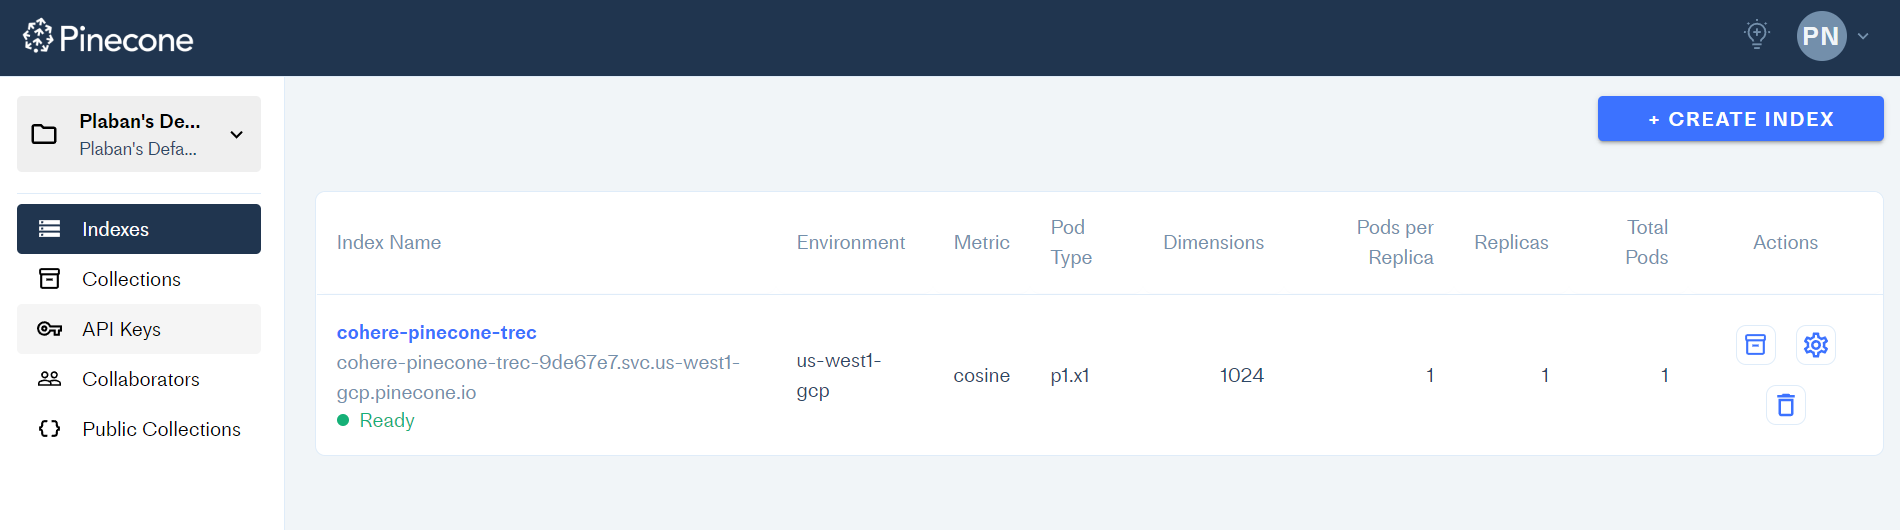

## Populate the index with the embeddings

In [20]:
# while uploading embeddings we do in batches to avoid pushing too much data in one go
batch_size = 128
ids = [str(i) for i in range(shape[0])]
#create list of metadata directories
meta = [{'text':text} for text in trec['text']]
#create a list of (id,vector,metadata)tuples to be upserted
to_upsert  = list(zip(ids,embed,meta))
#
for i in range(0,shape[0],batch_size):
  i_end = min(i+batch_size,shape[0])
  index.upsert(vectors=to_upsert[i:i_end])
#view index statistics
index.describe_index_stats()

{'dimension': 1024,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}

* index_fullness represents how full the index is at the moment
* 1024 dimensionality vector with 1000 sample
* for a default pod p1 approx 750k embeddings before the index_fullness reaches capacity
* we can identify the number of pods required for a given number of n dimensional embeddings

## Semantic Search

In [21]:
# embed query using cohere
query = "What caused the 1929 Great Depression?"
xq = co.embed(
  model='small',
  texts=[query],
  truncate='LEFT').embeddings

In [23]:
print(np.array(xq).shape)

(1, 1024)


In [24]:
#query returning top 10 most similar results
res = index.query(xq,top_k=10,include_metadata=True)
res

{'matches': [{'id': '932',
              'metadata': {'text': 'Why did the world enter a global '
                                   'depression in 1929 ?'},
              'score': 0.832428038,
              'sparseValues': {},
              'values': []},
             {'id': '787',
              'metadata': {'text': "When was `` the Great Depression '' ?"},
              'score': 0.752411664,
              'sparseValues': {},
              'values': []},
             {'id': '400',
              'metadata': {'text': 'What crop failure caused the Irish Famine '
                                   '?'},
              'score': 0.499363393,
              'sparseValues': {},
              'values': []},
             {'id': '160',
              'metadata': {'text': 'What war did the Wanna-Go-Home Riots occur '
                                   'after ?'},
              'score': 0.338738739,
              'sparseValues': {},
              'values': []},
             {'id': '835',
            

In [25]:
for match in res['matches']:
  print(f"{match['score']:.2f}: {match['metadata']['text']}")

0.83: Why did the world enter a global depression in 1929 ?
0.75: When was `` the Great Depression '' ?
0.50: What crop failure caused the Irish Famine ?
0.34: What war did the Wanna-Go-Home Riots occur after ?
0.34: What were popular songs and types of songs in the 1920s ?
0.34: What caused the Lynmouth floods ?
0.33: When did the Dow first reach ?
0.32: When did World War I start ?
0.32: What is considered the costliest disaster the insurance industry has ever faced ?
0.31: What caused Harry Houdini 's death ?


# replace keyword depression with recession

In [26]:
# embed query using cohere
query = "What was the cause of the major recession in the early 20th century?"
xq = co.embed(
  model='small',
  texts=[query],
  truncate='LEFT').embeddings

In [27]:
#query returning top 10 most similar results
res = index.query(xq,top_k=10,include_metadata=True)
res

{'matches': [{'id': '932',
              'metadata': {'text': 'Why did the world enter a global '
                                   'depression in 1929 ?'},
              'score': 0.660024107,
              'sparseValues': {},
              'values': []},
             {'id': '787',
              'metadata': {'text': "When was `` the Great Depression '' ?"},
              'score': 0.608734846,
              'sparseValues': {},
              'values': []},
             {'id': '400',
              'metadata': {'text': 'What crop failure caused the Irish Famine '
                                   '?'},
              'score': 0.431332,
              'sparseValues': {},
              'values': []},
             {'id': '969',
              'metadata': {'text': 'What are some of the significant '
                                   'historical events of the 1990s ?'},
              'score': 0.431040823,
              'sparseValues': {},
              'values': []},
             {'id': '835',


In [28]:
for match in res['matches']:
  print(f"{match['score']:.2f}: {match['metadata']['text']}")

0.66: Why did the world enter a global depression in 1929 ?
0.61: When was `` the Great Depression '' ?
0.43: What crop failure caused the Irish Famine ?
0.43: What are some of the significant historical events of the 1990s ?
0.37: What were popular songs and types of songs in the 1920s ?
0.36: When did the Dow first reach ?
0.35: What war did the Wanna-Go-Home Riots occur after ?
0.34: What historical event happened in Dogtown in 1899 ?
0.33: What is considered the costliest disaster the insurance industry has ever faced ?
0.31: What was the education system in the 1960 's ?


* the results are mostly similar just that similarity scores decreased

In [29]:
# embed query using cohere
query = "What was there a long-term economic in the early 20th century?"
xq = co.embed(
  model='small',
  texts=[query],
  truncate='LEFT').embeddings

In [30]:
#query returning top 10 most similar results
res = index.query(xq,top_k=10,include_metadata=True)
res

{'matches': [{'id': '932',
              'metadata': {'text': 'Why did the world enter a global '
                                   'depression in 1929 ?'},
              'score': 0.459475398,
              'sparseValues': {},
              'values': []},
             {'id': '787',
              'metadata': {'text': "When was `` the Great Depression '' ?"},
              'score': 0.433981,
              'sparseValues': {},
              'values': []},
             {'id': '969',
              'metadata': {'text': 'What are some of the significant '
                                   'historical events of the 1990s ?'},
              'score': 0.421619624,
              'sparseValues': {},
              'values': []},
             {'id': '835',
              'metadata': {'text': 'What were popular songs and types of songs '
                                   'in the 1920s ?'},
              'score': 0.372014642,
              'sparseValues': {},
              'values': []},
             

In [31]:
for match in res['matches']:
  print(f"{match['score']:.2f}: {match['metadata']['text']}")

0.46: Why did the world enter a global depression in 1929 ?
0.43: When was `` the Great Depression '' ?
0.42: What are some of the significant historical events of the 1990s ?
0.37: What were popular songs and types of songs in the 1920s ?
0.37: What was the education system in the 1960 's ?
0.33: When did the Dow first reach ?
0.32: When did Rococo painting and architecture flourish ?
0.31: What do economists do ?
0.31: How much was the minimum wage in 1991 ?
0.30: What crop failure caused the Irish Famine ?


* again we see the top 2 results being the same